## CPSC 7260 Presentation:
## Universal probabilistic programming offers a powerful approach to statistical phylogenetics 

Anna Su

11/19/2025

In [1]:
import treeppl
%load_ext treeppl.ipython

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from Bio import Phylo

sns.set_theme()

## CRBD Diversification Example

### Generating a CRBD tree

This section defines a generative constant-rate birth-death (CRBD) tree model in TreePPL. The function `generativeCrbd(time, lambda, mu)` returns a `Tree` sampled from a birth-death process run for `time` units with speciation rate `lambda` and extinction rate `mu`.

In [32]:
%%treeppl generative_crbd samples=1

model function generativeCrbd(time: Real, lambda: Real, mu: Real) => Tree {

  // Draw a waiting time to the next event (speciation or extinction) from an Exponential distribution
  assume waitingTime ~ Exponential(lambda + mu);
  let eventTime = time - waitingTime;

  // Base case: if the event time is negative, return a leaf node
  if eventTime < 0.0 {
    return Leaf {age = 0.0};
  } else {
    // O.w. decide whether the event is a speciation or extinction from a Bernoulli distribution
    assume isSpeciation ~ Bernoulli(lambda / (lambda + mu));

    // If the event is a speciation, recursively generate left and right subtrees
    if isSpeciation {
      return Node {
        left = generativeCrbd(eventTime, lambda, mu),
        right = generativeCrbd(eventTime, lambda, mu),
        age = eventTime
      };
    } else {
      // If the event is an extinction, return a leaf node
      return Leaf {age = eventTime};
    }
  }
}

This cell runs the `generative_crbd` model defined above with concrete parameter values and shows one sampled tree.

**Tip**: change `params['time']`, `lambda`, and `mu` to explore different regimes (e.g., high extinction vs low extinction).

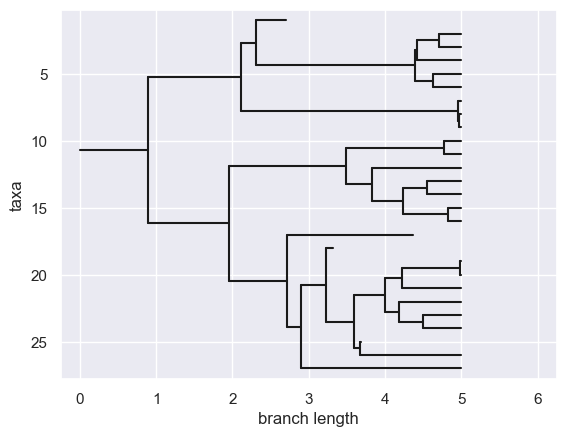

In [31]:
params = {
    "time": 5.0,
    "lambda": 1.0,
    "mu": 0.1
}

# Generates a tree using the generative CRBD model with specified parameters
# Returns an object with samples(the sampled trees) and norm_const / weights
result = generative_crbd(**params)

# Get the first sampled tree and convert it to a Biopython Clade for visualization
tree = result.samples[0]
tree = Phylo.BaseTree.Clade(
    branch_length=params["time"] - tree.age,
    clades=[tree.to_biopython()],
)
Phylo.draw(tree)

### Inferring parameters of a CRBD model

This part defines an importance-sampling (weighted) / SMC-style model to infer `lambda` and `mu` given an observed tree. The supporting functions: `simulateExtinctSubtree`, `simulateUnobservedSpeciations`, and `walk` are used to compute the conditional likelihood (with weights) of the observed reconstructed tree under the CRBD model.

In [28]:
%%treeppl crbd samples=10000 subsamples=10

// Simulates subtree lineages that go extinct within time — used to account for unobserved lineages when conditioning on the observed tree. 
// If no extinction occurs (waiting time > time) this trajectory is discarded (weight 0).
function simulateExtinctSubtree(time: Real, lambda: Real, mu: Real) {
  assume waitingTime ~ Exponential(lambda + mu);
  if waitingTime > time {
    weight 0.0; resample;
  } else {
    assume isSpeciation ~ Bernoulli(lambda / (lambda + mu));
    if isSpeciation {
      simulateExtinctSubtree(time - waitingTime, lambda, mu);
      simulateExtinctSubtree(time - waitingTime, lambda, mu);
    }
  }
}

// Simulates hidden speciation events along an observed branch and increments the importance weight when such events are compatible with the observation.
function simulateUnobservedSpeciations(node: Tree, time: Real, lambda: Real, mu: Real) {
  assume waitingTime ~ Exponential(lambda);
  if time - waitingTime > node.age {
    simulateExtinctSubtree(time - waitingTime, lambda, mu);
    weight 2.0;
    simulateUnobservedSpeciations(node, time - waitingTime, lambda, mu);
  }
}

// Walks the observed tree, simulating unobserved speciations and conditioning on no extinction along observed branches.
function walk(node: Tree, time:Real, lambda: Real, mu: Real) {
  simulateUnobservedSpeciations(node, time, lambda, mu);
  observe 0 ~ Poisson(mu * (time - node.age));
  if node is Node {
    observe 0.0 ~ Exponential(lambda);
    walk(node.left, node.age, lambda, mu);
    walk(node.right, node.age, lambda, mu);
  }
}

// Main model function to infer lambda and mu given an observed tree.
model function crbd(tree: Tree) => Real[] {

  // Places priors on lambda and mu (Gamma priors here).
  assume lambda ~ Gamma(1.0, 1.0);
  assume mu ~ Gamma(1.0, 0.5);

  // Runs walk on the two descendants of the root to compute the likelihood weight.
  walk(tree.left, tree.age, lambda, mu);
  walk(tree.right, tree.age, lambda, mu);


  // Returns the parameter vector which can be collected as weighted samples.
  return [lambda, mu];
}

**Collecting weighted samples and visualizing posteriors**:
This loop calls the `crbd` inference model repeatedly to collect weighted samples of `(lambda, mu)`. Each call returns a sample plus a log-weight (importance weight stored in `res.norm_const`).

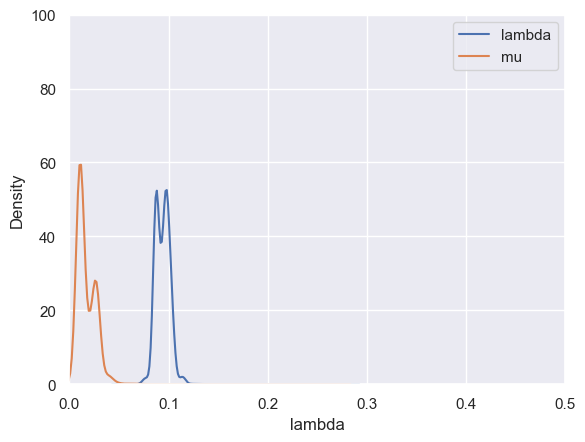

In [29]:
#  Loads an observed tree
alcedinidae = treeppl.Tree.load("trees/Accipitridae.tre.phyjson", format="phyjson")

samples = None

# Calls crbd in a loop and appends samples and their log-weights into a DataFrame.
for i in range(100):
    try:
        res = crbd(tree=alcedinidae)
        samples = pd.concat([
            samples,
            pd.DataFrame({
                "lambda": res.items(0), "mu": res.items(1), "lweight": res.norm_const
            })
        ])

        # Converts log-weights to normalized weights for plotting via exponential re-scaling
        weights = np.exp(samples.lweight - samples.lweight.max())
        clear_output(wait=True)

        # Plots kernel density estimates for lambda and mu using weights
        sns.kdeplot(data=samples, x="lambda", weights=weights, label="lambda")
        sns.kdeplot(data=samples, x="mu", weights=weights, label="mu")
        plt.legend()
        plt.xlim(0, 0.5)
        plt.ylim(0, 100)
        plt.pause(0.05)
    except KeyboardInterrupt:
        break

## DNA Sequence Example

This section shows backwards tree reconstruction based on aligned DNA sequence data (converted to integers) as input, and using the Jukes-Cantor model of nucleotide substitution, which assumes that all four nucleotides mutate into one another with equal probability and appear with equal frequencies (25% each) in the sequence.

Input data is a matrix, with each row consisting of the aligned DNA sequence for a single taxon. The nucleotide is specified as:

 "A" for adenine 0\
 "C" for cytosine 1\
 "G" for guanine 2\
 "T" for thymine 3\
 "-" currently not handled in this model

In [ ]:
%%treeppl myModel samples=1000 subsamples=10

// TYPES

type SeqTree =
  | Leaf {age: Real, seq: Int[]}
  | Node {age: Real, seq: Int[], left: SeqTree, right: SeqTree}

// FUNCTIONS

// Build forest of trees from leaves, recursively
// This list is called a “forest” because, at the start, you have many small trees (each leaf is a trivial tree). 
// Throughout the algorithm the forest shrinks until only one tree (the inferred phylogeny) remains.
function buildForest(data: Int[][], forest: SeqTree[], index: Int, dataLen: Int) => SeqTree[]
{
    // Convert each sequence in data into a Leaf with age 0 and add to forest
    let newLeaf = Leaf{age=0.0, seq=data[index]};
    let new_forest = paste0([forest, [newLeaf]]);
    if (dataLen == index) {
        return new_forest;
    }
    else {
        return buildForest(data, new_forest, index + 1, dataLen);
    }
}

// Randomly sample two indices in the trees vector, to be combined. Avoiding mirror cases.
function pickpair(n: Int) => Int[] {
    assume i_1 ~ Categorical(rep(n - 1, 1./Real(n - 1)));
    let i = i_1 + 2; //Adding two, avoiding index zero for i and avoiding trouble picking j
    assume j ~ Categorical(rep(i - 1, 1./Real(i - 1)));  // j is always smaller than i, avoiding mirror cases
    return [i, j + 1]; //avoid index of zero for j
}

//Note: this is not optimal, in terms of repeated calculation of matrix exp
function ctmc(initialstate: Int, q: Matrix[Real], t: Real) => Real[]
{
    let choices = [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]];
    let state = rvecCreate(4, choices[initialstate + 1]);
    let p = state *@ (mtxExp(q *$ t));
    return[mtxGet(1, 1, p), mtxGet(1, 2, p), mtxGet(1, 3, p), mtxGet(1, 4, p)];
}

// Recursive clustering function to build the tree
function cluster(q: Matrix[Real], trees: SeqTree[], maxAge: Real, seqLen: Int) => SeqTree[]
{
    let n = length(trees);

    // Check if we have reached the root of the tree
    if (n == 1) {
        return trees;
    }
    // Randomly sample two indices in the trees vector with function pickpair
    // We will combine these, named left and right child
    let pairs = pickpair(n);
    let leftChild = trees[pairs[1]];
    let rightChild = trees[pairs[2]];

    // Get the age of the new internal node
    assume t ~ Exponential(10.0);
    let age = maxAge + t;

    // Propose ancestral state(s) from stationary distribution, to be corrected later
    // This is just a proposal; weights will adjust its plausibility
    let seq = iid(categorical, CategoricalParam{probs=[0.25, 0.25, 0.25, 0.25]}, seqLen);

    // Observe the child states given the proposed state of parent node
    for i in 1 to seqLen {
        let p1 = ctmc(seq[i], q, age-leftChild.age);

        // Score how well the proposal matches each child
        observe leftChild.seq[i] ~ Categorical(p1);
        if (leftChild is Node) {
            logWeight -(categoricalLogScore(leftChild.seq[i], CategoricalParam{probs=[0.25, 0.25, 0.25, 0.25]}));
        }
        let p2 = ctmc(seq[i], q, age-rightChild.age);
        observe rightChild.seq[i] ~ Categorical(p2);
        if (rightChild is Node) {
            logWeight -(categoricalLogScore(rightChild.seq[i], CategoricalParam{probs=[0.25, 0.25, 0.25, 0.25]}));
        }
    }

    // Combine picked pair of trees into a new node
    let parent = Node{age=age, seq=seq, left=leftChild, right=rightChild};

    // Compute new_trees list
    let min = pairs[2];
    let max = pairs[1];
    let new_trees = paste0([slice(trees, 1, min), slice(trees, min + 1, max), slice(trees, max + 1, n + 1), [parent]]);

    // Recursive call to cluster for new_trees
    return cluster(q, new_trees, age, seqLen);
}

// MODEL

model function myModel(data: Int[][]) => SeqTree[]
{
    // Define the scaled rate matrix for Jukes-Cantor
    let q = mtxCreate(4,4,
        [     -1.0, (1.0/3.0), (1.0/3.0), (1.0/3.0),
        (1.0/3.0),      -1.0, (1.0/3.0), (1.0/3.0),
        (1.0/3.0), (1.0/3.0),      -1.0, (1.0/3.0),
        (1.0/3.0), (1.0/3.0), (1.0/3.0),      -1.0]
        );

    let dataLen = length(data);
    let seqLen =  length(data[1]);

    // Define the initial trees vector (containing the leaves)
    let trees = buildForest(data, [], 1, dataLen);

    // Build the tree by random clustering and return
    return cluster(q, trees, 0.0, seqLen);
}

The forest is simply the working set of partial trees; each iteration pops two, glues them into an older ancestor, and pushes the combined tree back until only the reconstructed tree remains.

In [ ]:
import json

with open("models/tree-inference/data/testdata_tree_inference.json", "r") as fh:
    js = json.load(fh)
testdata = js["data"]

res = myModel(data=testdata)
